## Imports

In [1]:
# Auto reload modules
%load_ext autoreload
%autoreload 2

In [3]:
# Standard Libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
from pathlib import Path
# RSA specific libraries

# Multiple Clocks Repositiory
import mc
import mc.analyse.analyse_MRI_behav     as analyse_MRI_behav
import mc.analyse.extract_and_clean     as extract_and_clean
import mc.simulation.predictions        as predictions
import mc.simulation.RDMs               as RDMs
import mc.replay_analysis.functions.utils         as utils
import mc.replay_analysis.functions.visualise     as v
import mc.replay_analysis.functions.model_rdms as function_model_rdms



In [4]:

REGRESSION_VERSION = '01' 
RDM_VERSION        = '01-2' 

SUBJECT_NO = '01'

# Behavioural data directory
DATA_DIR = Path("/Users/student/PycharmProjects/data")
DATA_DIR_BEHAV = DATA_DIR / 'raw' / 'sub-{SUBJECT_NO}' / 'beh'

TEMPORAL_RESOLUTION = 10
subjects_list: list = [f"sub-{SUBJECT_NO}"]
sub = subjects_list[0]
task_halves: list = ['1', '2']

# Flag to plot the RDMs
FMRI_PLOTTING = True
# Flag to save the RDMs and the regressors
FMRI_SAVE = True
RDM_SIMILARITY_MEASURE = "pearson" # default is 'pearson'
ADD_RUN_COUNTS_MODEL = False # this doesn't work with the current analysis

# Get the list of the models to analyse  
models_i_want: list = analyse_MRI_behav.models_I_want(RDM_VERSION)



## get correct working directory

In [5]:
configs_dict = {}
models_between_task_halves = {}

# for each half of the task do the following
for task_half in task_halves:
    # 1. Extract the behavioural data from the .csv to appropriate dictionaries
    # Select the correct file path as a directory for the behavioural .csv file
    DATA_DIR_BEHAV = DATA_DIR / 'raw' / f'{sub}' / 'beh'

    RDM_dir = DATA_DIR / 'derivatives' / f'{sub}' / 'beh' / f'RDMs_{RDM_VERSION}_glmbase_{REGRESSION_VERSION}'

    if os.path.isdir(DATA_DIR_BEHAV):
        print("Running on laptop.")
    else:
        DATA_DIR_BEHAV = DATA_DIR / f'{sub}' / 'beh'
        RDM_dir = '{DATA_DIR}' /'derivatives' / f'{sub}' / 'beh' / 'RDMs_{RDM_VERSION}_glmbase_{REGRESSION_VERSION}'
        print(f"Running on Cluster, setting {DATA_DIR_BEHAV} as data directory")
        
    # file = data_dir_behav + f"{sub}_fmri_pt{task_half}.csv"
    file = f"{DATA_DIR}/raw/sub-01/beh" + f"/{sub}_fmri_pt{task_half}.csv"

    # 1. Extract the behavioural data from the .csv to appropriate dictionaries
    configs, rew_list, rew_index, walked_path, steps_subpath_alltasks_empty, subpath_after_steps, timings, regressors = analyse_MRI_behav.extract_behaviour(file)

    # 2. Create the regressors for the GLM
    # so now, account for the temporal resolution that you want
    for reg in regressors:
        # For each regressor, 
        regressors[reg] = np.repeat(regressors[reg], repeats = TEMPORAL_RESOLUTION)
    
    # Overview of the reward fields per task.
    steps_subpath_alltasks = analyse_MRI_behav.subpath_files(configs, subpath_after_steps, rew_list, rew_index, steps_subpath_alltasks_empty)

    # prepare the between-tasks dictionary.
    all_models_dict = {f"{model}": {key: "" for key in configs} for model in models_i_want}

    # then, lastly, save the all_models_dict in the respective task_half.
    models_between_task_halves[task_half] = all_models_dict
    print(f"task half {task_half}")
    configs_dict[task_half] = rew_list





Running on laptop.
task half 1
Running on laptop.
task half 2


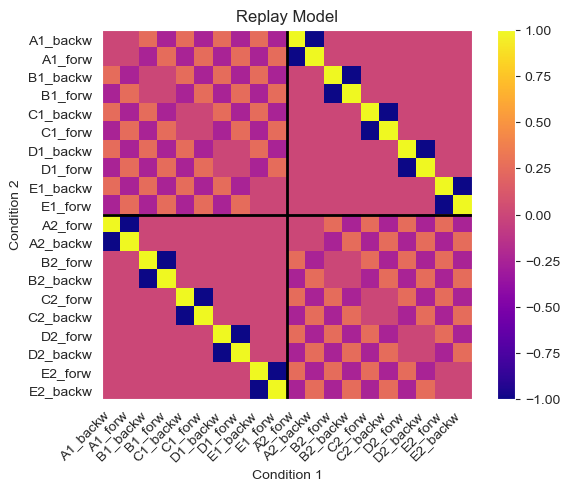

In [16]:
RDM_VERSION = '01-2'


# Create sorted_keys_dict for the RDMs
sorted_keys_dict = extract_and_clean.order_task_according_to_rewards(configs_dict)
# create dictionary (for both halves, splits) that contains the neural model for each condition being tested
replay_RDM_object = function_model_rdms.task_similarity_matrix(
    configs_dict = configs_dict,
    model = "replay",
    RDM_dir = RDM_dir,
    VISUALISE = True
)




In [6]:

# then, in a last step, create the RDMs
# concatenate the conditions from the two task halves (giving you 2*nCond X nVoxels matrix), 
# and calculate the correlations between all rows of this matrix. This gives you a symmetric matrix 
# (of size 2*nCond X 2*nCond), where the (non-symmetric) nCond X nCond bottom left square (or top right, 
# doesn't matter because it's symmetric) (i.e. a quarter of the original matrix) has all the correlations 
# across THs. 

# NOTE: the formatting for these dictationaries are the opposite nesting of what is expected from the script.
# reverse the nesting of the dictionaries.

# flip the keys and values of the dictionary.
models_sorted_into_splits = utils.reverse_nested_dict(models_sorted_into_splits)

# FROM THE NEURAL MODELS, CREATE THE RDMs

# for each split (half)
for split in models_sorted_into_splits:
    RSM_dict_betw_TH = {}
    # for each model in the split (half), create the RSM and place it in a dictionary
    for model in models_sorted_into_splits[split]:
        RSM_dict_betw_TH[model] = RDMs.construct_within_task_RSM(
            # The matrix being used is the concatenation of the models between both task halves
            neuron_activation_matrix = np.concatenate(
                # First half of task (as a vector for each EV)
                (models_sorted_into_splits['1'][model],
                # Second half of task
                    models_sorted_into_splits['2'][model]),
                # the axis along which the concatenation is done
                1), 
            SIMILARITY_MEASURE = RDM_SIMILARITY_MEASURE,
            plotting    = True, 
            titlestring = model,
            neural_model = False)

        
# correct the RSM for dealing with 
corrected_RSM_dict = analyse_MRI_behav.auto_corr_RSM_dict(RSM_dict_betw_TH)


# just for me. what happens if I add the ['reward_location', 'one_future_rew_loc' ,'two_future_rew_loc', 'three_future_rew_loc']?
# addition_model = corrected_RSM_dict['reward_location'] + corrected_RSM_dict['one_future_rew_loc'] + corrected_RSM_dict['two_future_rew_loc'] + corrected_RSM_dict['three_future_rew_loc'] 


NameError: name 'models_sorted_into_splits' is not defined

## For your own visiualisation and saving

In [ ]:

# Plot the RDMs
if FMRI_PLOTTING == True:
    # create directory for saving the RDM images
    if not os.path.exists(RDM_dir):
        os.makedirs(RDM_dir)

    # plot the RDMs from the RSM dictionary
    RDMs.plot_RDMs(
        RDM_dict = corrected_RSM_dict, 
        save_dir = RDM_dir, 
        string_for_ticks = sorted_keys_dict['1'])

# Save the RDMs
if FMRI_SAVE == True: 
    # then save these matrices.
    if not os.path.exists(RDM_dir):
        os.makedirs(RDM_dir)
    for RDM in corrected_RSM_dict:
        np.save(os.path.join(RDM_dir, f"RSM_{RDM}_{sub}_fmri_both_halves"), corrected_RSM_dict[RDM])

    # also save the regression files
    for model in models_sorted_into_splits['1']:
        np.save(os.path.join(RDM_dir, f"data{model}_{sub}_fmri_both_halves"), np.concatenate(
            (models_sorted_into_splits['1'][model], 
                models_sorted_into_splits['2'][model]),
                1))
    
    # and lastly, save the order in which I put the RDMs.

    # save the sorted keys and the regressors.
    with open(f"{RDM_dir}/sorted_keys-model_RDMs.pkl", 'wb') as file:
        pickle.dump(sorted_keys_dict, file)
    
    with open(f"{RDM_dir}/sorted_regs.pkl", 'wb') as file:
        pickle.dump(reg_list, file)
            


